In [2]:
from tinygrad import Tensor
from tinygrad.nn import Embedding, Linear
from tinygrad.nn.optim import Adam
from tinygrad.nn.state import get_parameters
from tinygrad.jit import TinyJit
from tinygrad.graph import print_tree
from tinygrad.helpers import DEBUG

from model import LSTM
from utils import imshow
from train import TransducerLoss, mask, unshear
from data import load_data, text_encode

import matplotlib.pyplot as plt
import numpy as np

ram used:  0.18 GB, joint.l2.bias                                     : 100%|██████████| 33/33 [00:00<00:00, 739.05it/s]

loaded weights in  54.75 ms, 0.18 GB loaded at 3.31 GB/s


In [3]:
ci, _, maxY = load_data(10)
maxX = maxY
transcripts = [i['transcript'] for i in ci]
del ci
no_vowels = ["".join([c for c in line if c not in 'aeiou']) for line in transcripts]
just_vowels = ["".join([c for c in line if c in 'aeiou']) for line in transcripts]

In [4]:
xsource = no_vowels
ysource = transcripts

maxX = max(map (len, xsource))
maxY = max(map (len, ysource))

def iterate(BS):

    def pack(lines, maxLen):
        x, xlens = text_encode(np.array(lines))
        x = Tensor(x).pad(((0,0),(0,maxLen - x.shape[1]))).contiguous().realize()
        return x,Tensor(xlens)

    for i in range(0,len(transcripts) - BS, BS):
        x,xlens = pack(xsource[i:i+BS], maxX)
        y,ylens = pack(ysource[i:i+BS], maxY)
        yield x,y,xlens, ylens

In [5]:
DEBUG.value = 0
BS = 8
VOCAB = 28
EMBED = 16
iter = iterate(BS)

In [6]:
HDIM = 1024
class RNNT :
    def __init__(self):
        self.xemb = Embedding(VOCAB, EMBED)
        self.encoder = LSTM (EMBED, HDIM, 3, 0)
        self.yemb = Embedding(VOCAB, EMBED)
        self.predictor = LSTM(EMBED, HDIM, 1, 0)
        self.joint = Linear(HDIM*2, VOCAB+1)
    
    def encode(self, x):
        x = self.xemb(x)
        return self.encoder(x.T)[0].T

    def predict(self,y):
        y = self.yemb(y)
        return self.predictor(y.T)[0].T
    
    def join(self, x, y):
        global j
        x = self.encode(x)
        y = self.predict(y).pad (((0,0),(1,0),(0,0)))

        x = x.unsqueeze(2).expand(-1, -1, y.shape[1], -1)
        y = y.unsqueeze(1).expand(-1, x.shape[1], -1, -1)

        d = x.cat(y, dim = -1)
        j = self.joint(d)
        return j.softmax(-1)

model = RNNT()
opt = Adam(get_parameters(model))
def stack(X:list[Tensor]):
    R = X[0].unsqueeze(1)
    for x in X[1:]:
        R = R.cat(x.unsqueeze(1), dim=1).realize()
    return unshear(R.transpose(1,2)).transpose(1,2)

def analysis():
    global A, B, AB, skip, p
    A = stack(ctx.a).realize()
    B = stack(ctx.b).realize()
    AB = A[0] + B[0]
    AB = AB - AB.max()
    skip = unshear(ctx.skip.transpose(1,2)).transpose(1,2).realize()
    p = unshear(ctx.p.transpose(1,2)).transpose(1,2).realize()

    AB = AB[:xlens[0].numpy(), :ylens[0].numpy()]
    skip = skip[:xlens[0].numpy(), :ylens[0].numpy()]
    p = p[:xlens[0].numpy(), :ylens[0].numpy()]


In [11]:
@TinyJit
def step(x,y,xlens,ylens):
    opt.zero_grad()
    loss = forward(x,y,xlens, ylens)
    print("pre loss:",loss.numpy().item())
    loss.backward()
    for p in opt.params: p.grad.realize()
    opt.step()
    print ("post loss:", loss.numpy().item())
    return loss.realize()

def forward(x,y,xlens, ylens):
    global d, ctx
    d = model.join(x,y)
    d = mask(d, xlens, ylens, maxX, maxY, VOCAB)
    L = TransducerLoss.apply(d, y)
    ctx = L._ctx
    return L.realize()

In [12]:
def epoch():
    for i, sample in enumerate(iterate(BS)):
        global x,y,xlens,ylens,L
        x,y,xlens,ylens = sample
        L = (step(x,y,xlens,ylens)).numpy()
        print (f"{i}/{int(len(transcripts)/BS)} {L = } l:{L.item() / xlens.sum().numpy()}")

        # if L == 0 : break
        if i % 10 == 0:
            L = forward(x,y,xlens,ylens)
            L.backward()
            analysis()
            imshow(AB.exp())

In [13]:
iter = iterate(BS)

In [17]:
x,y,xlens,ylens = next(iter)
opt.zero_grad()
L = forward(x,y,xlens,ylens)
L.backward()

opt.step()
L.realize()     
print(L.numpy())
print(L.numpy())
print(L.numpy())

0.0
0.0
0.0


In [605]:
L = forward(x,y,xlens,ylens)

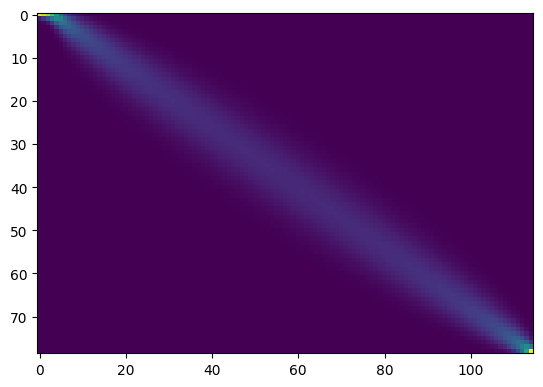

In [606]:
L.backward()
analysis()
imshow(AB.exp())

In [563]:
x,y,xlens,ylens = next(iterate(BS))
L = forward(x,y,xlens,ylens)
L.backward()
analysis()
dgrad = d.grad[0,:xlens[0].numpy(),:ylens[0].numpy(),-1]

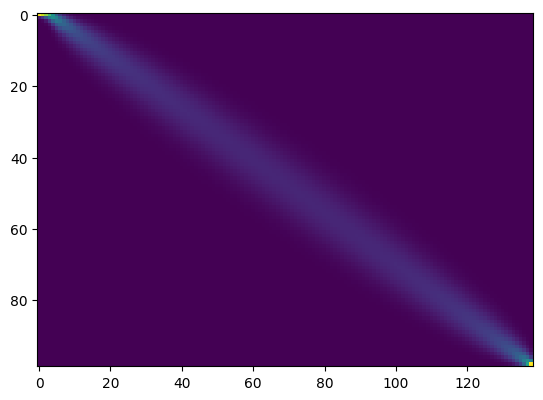

In [600]:
imshow(AB.exp()[:,:])

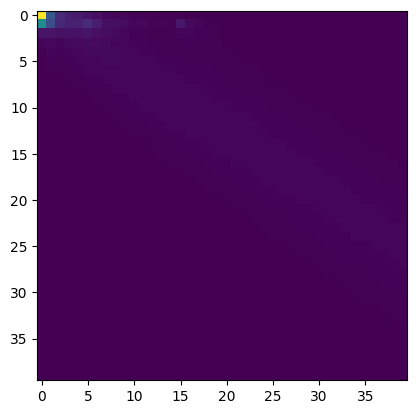

In [592]:
imshow(-dgrad[:40,:40])

In [566]:
i = 0

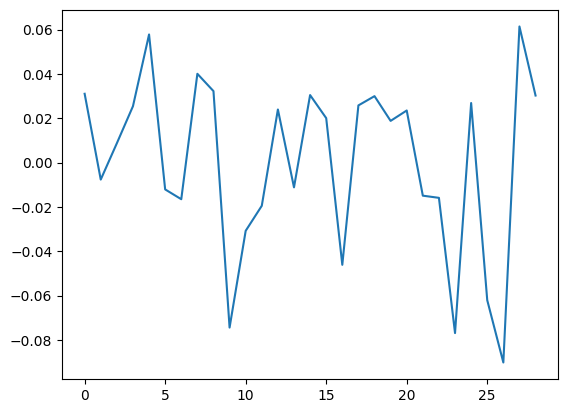

In [591]:
plt.plot(j[0,0,0].numpy())

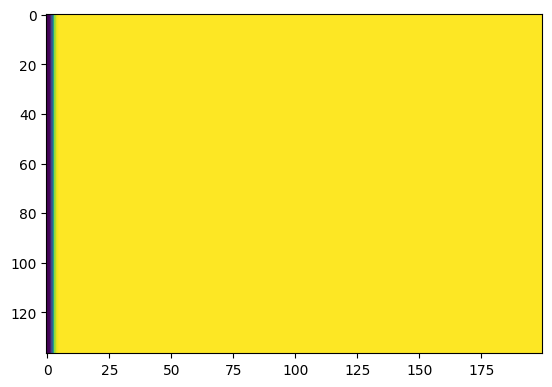

In [590]:
# for i in range(29):
imshow(j[0,:,:,-1].softmax(-1))


In [411]:
d[0,0,0].numpy().sum()

0.99999994

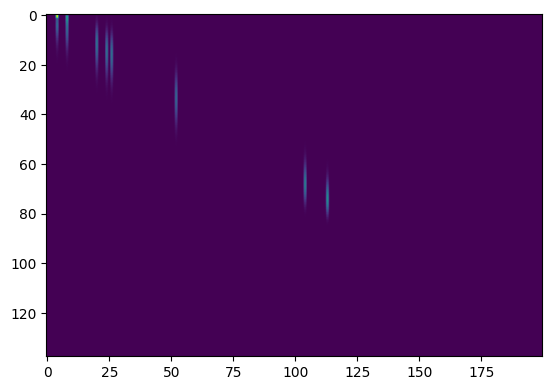

In [384]:
imshow(-d.grad[0,:,:,0])